In [1]:
import numpy as np
import copy
from scipy.stats import multivariate_normal
import matplotlib.pyplot as plt
import pandas as pd
import pickle as pkl

# Synthetic Datapoints to test the EM algorithm while building

In [ ]:
n=100 #number of points
d=2 #dimension of each point
k=2 #clusters

#randomly generate k number of  d-dimensional means
mus=np.random.random((k,d))*20-10 

#Data Generation
X=[]
for i in range(n):
    for j in range(k):
        X.append([mean+np.random.randn() for mean in mus[j]])
#we have our dataset, where each point is a d+1 dimensional tuple where the last position represents its class 

X = np.asarray(X)

# EM Algorithm

In [83]:
def EM(X,k):

    #dimension of the dataset
    d = X.shape[1]

    #number of points in the dataset
    n = X.shape[0]

    '''initialising means ---------------------------------'''
    # random means
    # old_mus = np.array([np.random.rand(d) for _ in range(k)])

    # select random datapoints from data as initial means
    random_rows = np.random.choice(X.shape[0], size=k, replace=False)
    old_mus = copy.deepcopy(X[random_rows, :])

    # choose means from unifrom random between 'a' and 'b' 
    # old_mus = np.random.random((k,d))*20-10 
    # old_mus = np.random.random((k,d))*np.max(X)-np.min(X)


    new_mus = copy.deepcopy(old_mus)
    # print('original',mus)
    # print("initial", new_mus)
    '''-------------------------------------------------------'''


    '''initalising covariance matrices-------------------------'''
    #identity matrices of dxd dimension as covariance matrices
    old_cov = np.asarray([np.eye(d) for _ in range(k)])
    new_cov = copy.deepcopy(old_cov)
    '''-------------------------------------------------------'''

    '''initialising priors-------------------------------------'''
    #priors are 1/k where k is the number of classes
    old_priors = np.full((k),1/k)
    new_priors = copy.deepcopy(old_priors)
    '''-------------------------------------------------------'''

    #stopping condition
    eps = 1e-02

    #starting time
    t = 0

    #aritifcal condition to enter the loop
    obt_eps = 1

    while (obt_eps > eps) or (t==0):
        t += 1

        '''Begin Expectation step---------------------------------------------------------'''
        #get the W matrix
        #unnormalised
        # W_temp = copy.deepcopy(tabulate(list(range(n)),list(range(k)),w_mat))
        # W_temp = np.array(list(map(w_mat, * np.meshgrid(list(range(n)), list(range(k))))))
        W_temp = np.zeros((k,n),dtype=float)
        for j in range(k):
            W_temp[j,:]= multivariate_normal.pdf(X,mean=new_mus[j],cov=new_cov[j],allow_singular=True) * new_priors[j]

        temp = copy.deepcopy(W_temp)
        #normalised
        W = copy.deepcopy(temp/temp.sum(axis=0))

        #it so happens that sometime, the probability of a point being assinged to any of the cluster is 0.
        #this is probably an artefact of multivariate.normal.pdf giving very small values 
        # and the 64 bit precision of the computer rounding stuff off to 0 or nan. 
        #When this happens, this part of the assigns the point to any of the clusters with equal probability.
        if np.isfinite(W).all():
            pass
        else:
            W_temp_where = np.where(temp.sum(axis=0)==0.0)
            for ii in W_temp_where:
                W[:,ii] = 1/k
        '''End Expectation step------------------------------------------------------------'''

        #get sum of W for each cluster
        temp = copy.deepcopy(W)
        sum_w = copy.deepcopy(temp.sum(axis=1))

        '''Begin Maximization step---------------------------------------------------------'''
        # re-estimate means
        old_mus = copy.deepcopy(new_mus)
        #unnormalised
        new_mus_temp = copy.deepcopy(W @ X)
        temp = copy.deepcopy(new_mus_temp)
        #normalised
        new_mus = copy.deepcopy(temp/sum_w[:,None])

        # re-estimate covariance
        old_cov = copy.deepcopy(new_cov)
        #unnormalised
        # new_cov_temp = copy.deepcopy([cov_loop(n,a) for a in range(k)])
        # temp = copy.deepcopy(new_cov_temp)
        #normalised
        # new_cov = copy.deepcopy([temp[a]/sum_w[a] for a in range(k)])
        new_cov = [
                    np.sum(
                            [
                                W[i,j]/(sum_w[i])*
                                (
                                    (np.expand_dims(X[j]-new_mus[i], axis=0).T) @ 
                                    np.expand_dims(X[j]-new_mus[i], axis=0)
                                ) 
                                for j in range(n)
                            ],axis=0
                        ) 
                        for i in range(k)
                     ]
        # new_cov = copy.deepcopy([cov_loop(n,a) for a in range(k)])



        # re-estimate priors
        old_priors = copy.deepcopy(new_priors)
        new_priors = copy.deepcopy(sum_w/n)
        '''End Maximization step---------------------------------------------------------'''

        obt_eps = np.sum([np.linalg.norm(new_mus[a]-old_mus[a]) for a in range(k)])
        print(obt_eps)
    # print("final", t,n,k,d,new_mus) 
    return W,new_mus,new_cov,t

def error_analysis(posterior_matrix,\
                    obtained_cluster_means,\
                    actual_means,\
                    df):
    #creating a final array from the dataframe
    posterior = pd.DataFrame(posterior_matrix)

    #hard assignment. Each point is assigned to a cluster which has the maxiumum value of P(C|X)
    clustered_points = posterior.idxmax().to_dict()

    #ground truth from data
    ground_truth_means = copy.deepcopy(actual_means)

    #ground truth from data
    # ground_truth_cov = copy.deepcopy(actual_cov)

    #dictionary which maps the k cluster (means) to 2 clusters (since the ground truth only has two clusters)
    assignment_of_means_to_clusters = {}
    for i,each_cluster in enumerate(obtained_cluster_means):
        #measure eucledian distance to each of the ground truth clusters from the kth cluster and 
        #assign the cluster label to the ground truth cluster closer to it
        if np.linalg.norm(ground_truth_means[0]-each_cluster) > np.linalg.norm(ground_truth_means[1]-each_cluster):
            assignment_of_means_to_clusters[i] = 1
        else:
            assignment_of_means_to_clusters[i] = 0

    # now that k mean labels have been mapped to two clusters, 
    # map the points of each of the obtained clusters to one of the two ground truth cluster. 
    # if point 1 is in the 4th cluster (obtained from EM algo) 
    # and the 4th cluster has been mapped to cluster X of the ground truth data,
    # then point 1 now belongs to cluster X
    final_assignment_of_points = {k:assignment_of_means_to_clusters[v] for k,v in clustered_points.items()}

    #for ringnorm, 0 label means the cluster 
    # with ground truth means 0 (of d dimension) and cov (4*identity) of 20x20dimension
    # 1 label means the cluster with ground truth means 2/sqrt(20) (of d-dimension) and cov identity of 20x20dimension

    ground_truth_assignment_of_points = df[len(actual_means[0])].to_dict()

    error_df = pd.DataFrame()
    error_df['assigned'] = final_assignment_of_points.values()
    error_df['ground_truth'] = ground_truth_assignment_of_points.values()


    error_0 = error_df[error_df['ground_truth'] == 0]
    #proportion of points which should be assigned to cluster 0 but were assigned to cluster 1 instead
    # error_01 = (len(error_0[error_0['assigned']==1])/len(error_0))
    error_01 = (len(error_0[error_0['assigned']==1])/len(error_df))

    error_1 = error_df[error_df['ground_truth'] == 1]
    #proportion of points which should be assigned to cluster 1 but were assigned to cluster 0 instead
    # error_10 = len(error_1[error_1['assigned']==0])/len(error_1)
    error_10 = len(error_1[error_1['assigned']==0])/len(error_df)

    # counter = 0
    # for index, row in error_df.iterrows():
    #     if row['ground_truth'] != row['assigned']:
    #         counter +=1
    # return counter


    return error_01,error_10


# Ringnorm analysis

In [87]:
# Loading data
# \s+ since dataset has one or more white spaces
df = pd.read_csv("Dataset.data",sep='\s+',header=None)

X = df.to_numpy()
X = X[:,:-1]

mus = np.asarray(
    [ [0]*X.shape[1],
        [2/np.sqrt(20)]*X.shape[1]
        ]
)

In [ ]:
#20 runs

posteriors,output_mus,output_covs,iterations = {},{},{},{}

for k in [2,3,4,5]:
    data = {}
    for e in range(20):
        print(f"k={k},e={e}")
        p,m,c,i = EM(X,k)
        posteriors[e] = p
        output_mus[e] = m
        output_covs[e] = c
        iterations[e] = i
    data['posteriors'] = posteriors
    data['output_mus'] = output_mus
    data['output_covs'] = output_covs
    data['iterations'] = iterations
    with open(f"ringnorm{k}.pkl",'wb') as f:
        pkl.dump(data,f)
        

In [ ]:
#single run
posterior,new_means,_,_ = EM(X,4)

Text(0, 0.5, 'number of clusters')

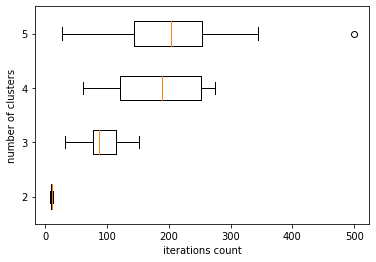

In [10]:
data = []
for k in [2,3,4,5]:
    with open(f"ringnorm{k}.pkl",'rb') as f:
        data.append(list(pkl.load(f)['iterations'].values()))
_  = plt.boxplot(data,vert=False,labels=['2','3','4','5'])

plt.xlabel('iterations count')
plt.ylabel('number of clusters')

In [ ]:
posteriors,output_mus,output_covs,iterations = {},{},{},{}

for k in [2,3,4,5]:
    data = {}
    for e in range(20):
        print(f"k={k},e={e}")
        p,m,c,i = EM(X,k)
        posteriors[e] = p
        output_mus[e] = m
        output_covs[e] = c
        iterations[e] = i
    data['posteriors'] = posteriors
    data['output_mus'] = output_mus
    data['output_covs'] = output_covs
    data['iterations'] = iterations
    with open(f"ringnorm{k}.pkl",'wb') as f:
        pkl.dump(data,f)
        

In [90]:
total_error = {}
for k in [2,3,4,5]:
    print(k)
    total_error[k] = []
    with open(f"ringnorm{k}.pkl",'rb') as f:
       data = pkl.load(f)
    for e in range(20):
        # counter = error_analysis(data['posteriors'][e],data['output_mus'][e],mus,df)
        error01,error10 = error_analysis(data['posteriors'][e],data['output_mus'][e],mus,df)
        total_error[k].append(error01+error10)

2
3
4
5


Text(0, 0.5, 'number of clusters')

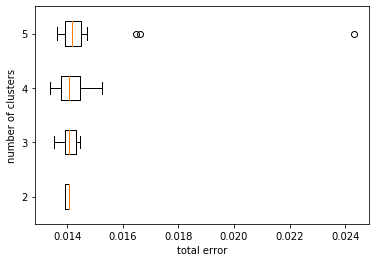

In [91]:
data = [total_error[k] for k in [2,3,4,5]]
_  = plt.boxplot(data,vert=False,labels=['2','3','4','5'])

plt.xlabel('total error')
plt.ylabel('number of clusters')

In [78]:
#\s+ since dataset has one or more white spaces
df = pd.read_csv("ionosphere.data",header=None)


In [79]:
X = df[list(range(34))].to_numpy()

mean_g = [i/len(df[df[34]=='g']) for i in df[df[34]=='g'].sum(axis=0).to_list()[:-1]]
mean_b = [i/len(df[df[34]=='b']) for i in df[df[34]=='b'].sum(axis=0).to_list()[:-1]]

mus = np.array([mean_g,mean_b])

Text(0, 0.5, 'number of clusters')

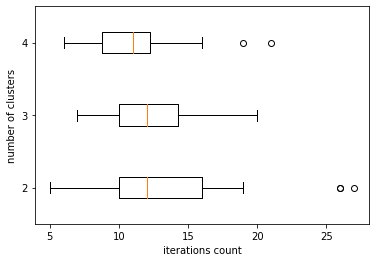

In [80]:
data = []
for k in [2,3,4]:
    with open(f"ionosphere{k}.pkl",'rb') as f:
        data.append(list(pkl.load(f)['iterations'].values()))
_  = plt.boxplot(data,vert=False,labels=['2','3','4'])

plt.xlabel('iterations count')
plt.ylabel('number of clusters')

In [84]:
df[df[34]=='g']=0
df[df[34]=='b']=1
total_error = {}
for k in [2,3,4]:
    print(k)
    total_error[k] = []
    with open(f"Ionosphere{k}.pkl",'rb') as f:
       data = pkl.load(f)
    for e in range(20):
        error_01,error_10 = error_analysis(data['posteriors'][e],data['output_mus'][e],mus,df)
        # counter = error_analysis(data['posteriors'][e],data['output_mus'][e],mus,df)
        total_error[k].append(error_01+error_10)
        # total_error[k].append(counter/len(df))

/Users/rachithaiyappa/anaconda3/lib/python3.7/site-packages/pandas/core/ops/__init__.py:1115: FutureWarning: elementwise comparison failed; returning scalar instead, but in the future will perform elementwise comparison
  result = method(y)


2
3
4


Text(0, 0.5, 'number of clusters')

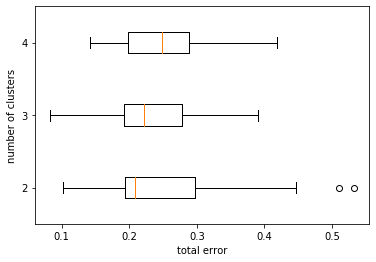

In [85]:
data = [total_error[k] for k in [2,3,4]]
_  = plt.boxplot(data,vert=False,labels=['2','3','4'])

plt.xlabel('total error')
plt.ylabel('number of clusters')